# Deep Cox Mixtures with Heterogenous Effects (CMHE) Demo
<hr>

Author: ***Mononito Goswami***  &lt;mgoswami@cs.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>






![](https://files.mdnice.com/user/36552/d3b3bd9b-8eae-47ef-a80f-a953b539a9fa.png)

## 图A：CMHE的示意图说明
特征集（混杂因素）$\mathbf{x}$会通过编码器得到深度非线性表示。这些表示随后描述潜在表型组$\mathbf{P}(Z|X = \mathbf{x})$和$\mathbf{P}(\phi|X = \mathbf{x})$，它们分别决定基准生存率和治疗效果。最终，干预$A = \mathbf{a}$下的个体水平风险（生存）曲线，是通过对$Z$和$\phi$求边缘分布得到的：$\mathbf{S}(t|X = x, A = a) = \mathbf{E}_{(Z,\phi) \sim \mathbf{P}(\cdot|X)} \big[ \mathbf{S}(t|A = \mathbf{a}, X, Z, \phi) \big]$。

**具有异质性效应的Cox混合模型（CMHE）** 是一种灵活的方法，用于在删失的生存时间结局下，恢复对干预表现出异质性效应的个体的反事实表型。CMHE不受严格的Cox比例风险假设，也不受生存时间分布的任何参数假设的限制。

CMHE的实现方式是：将每个个体描述为属于两个不同的潜在组——介导基准生存率的$Z$，以及介导治疗效果的$\phi$。CMHE也可用于建模个体水平的反事实，或用于标准的事实生存回归。


![](https://files.mdnice.com/user/36552/bb04afca-70b1-42d1-9744-11ee22a8bb37.png)

## 图B（右侧）：CMHE的图模型表示
$\mathbf{x}$是治疗分配$A$和结局$T$的混杂因素（模型参数和删失分布已被抽象省略）。


*有关“具有异质性效应的Cox混合模型”的完整细节，请参阅我们的预印本。*
[《基于删失生存时间的反事实表型分析》，arXiv预印本，作者：C. Nagpal、M. Goswami、K. Dufendach、A. Dubrawski](Counterfactual Phenotyping with Censored Time-to-Events, arXiv preprint, C. Nagpal, M. Goswami, K. Dufendach, A. Dubrawski)

<a id="syndata"></a>

## 2. Synthetic Data Example


In [6]:
# 运行当前目录下的 compatibility_solution.py 文件
%run compatibility_solution.py

In [13]:
# 导入 pandas 库，用于数据处理和分析，常用别名 pd
import pandas as pd
# 导入 PyTorch 深度学习框架，用于张量操作和模型训练
import torch
# 从 tqdm 库导入 tqdm 函数，用于在循环中显示进度条，提升长任务的可视化体验
from tqdm import tqdm 
# 导入 sys 模块，用于访问 Python 解释器相关变量和函数
import sys
# 将上级目录（'../'）添加到模块搜索路径，方便导入自定义模块
sys.path.append('../')

# 从 auton_survival 包的 datasets 模块导入 load_dataset 函数，用于加载生存分析数据集
from auton_survival.datasets import load_dataset
# 从当前目录的 cmhe_demo_utils 模块导入所有公开属性和函数，通常包含演示所需的工具函数
from cmhe_demo_utils import *


<a id="gensyndata"></a>
### 2.1. Generative Process for the Synthetic Data

1. 特征 $x_1$、$x_2$ 和基础生存表型 $Z$ 从 $\texttt{scikit-learn}$ 的 $\texttt{make_blobs(...)}$ 函数中采样，该函数生成各向同性的高斯 blob：
$$[x_1, x_2], Z \sim \texttt{sklearn.datasets.make_blobs(K = 3)}$$
2. 特征 $x_3$ 和 $x_4$ 均匀采样，而潜在的治疗效应表型 $\phi$ 根据 $L_1$-球定义：
$$ [x_3, x_4] \sim \texttt{Uniform}(-2, 2) $$
$$ \phi \triangleq \mathbb{1}\{|x_3| + |x_4| > 2\} $$
3. 接着从伯努利分布中采样处理分配：
$$ A \sim  \texttt{Bernoulli}(\frac{1}{2}) $$
4. 接下来，以混杂因素 $x$、潜在变量 $Z$ 和潜在效应组 $\phi$ 为条件的事件时间 $T$ 从 Gompertz 分布生成：
$$ T^{*}| (Z=k, {\phi}=m, A={a}) \sim \nonumber \texttt{Gompertz}\big({\beta}_{k}^{\top}{x} +({-a}^m)\big) $$
5. 最后，通过对部分事件进行删失，并随机均匀选择删失时间至 $T^*$，得到观测时间 $T$：
$$\delta \sim \texttt{Bernoulli}(\frac{3}{4}), \quad C \sim \texttt{Uniform}(0, {T}^{*})$$
$$ T =  \begin{cases} T^*, & \text{若 } \delta = 1 \\ C, & \text{若 } \delta = 0 \end{cases} $$


In [14]:
# Load the synthetic dataset
outcomes, features, interventions = load_dataset(dataset='SYNTHETIC')

# Let's take a look at take the dataset
features.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.148745,1.892484,0.195254,0.860757,0.696523,0.483697,0.339551,0.374794
1,1.139439,-0.943330,0.411054,0.179533,0.428686,0.683057,0.600948,0.070483
2,-0.961237,0.782706,-0.305381,0.583576,0.157478,0.070556,0.034590,0.776005
3,0.466508,0.694348,-0.249651,1.567092,0.850959,0.416178,0.968841,0.863598
4,-0.249002,-0.552091,1.854651,-0.466234,0.860385,0.367184,0.954347,0.748930


In [15]:
outcomes.head()

,event,time,uncensored time treated,uncensored time control,Z,Zeta
0,True,3.238760,3.238760,0.009182,1.0,0.0
1,True,3.493217,3.493217,6.307030,2.0,0.0
2,True,2.558462,1.476810,2.558462,1.0,0.0
3,True,5.582874,5.582874,4.593198,1.0,0.0
4,True,6.675284,3.477266,6.675284,0.0,1.0


In [16]:
interventions.head()

0    False
1    False
2     True
3    False
4     True
Name: intervention, dtype: bool

<a id="vissyndata"></a>
### 2.2. Visualizing the Synthetic Data

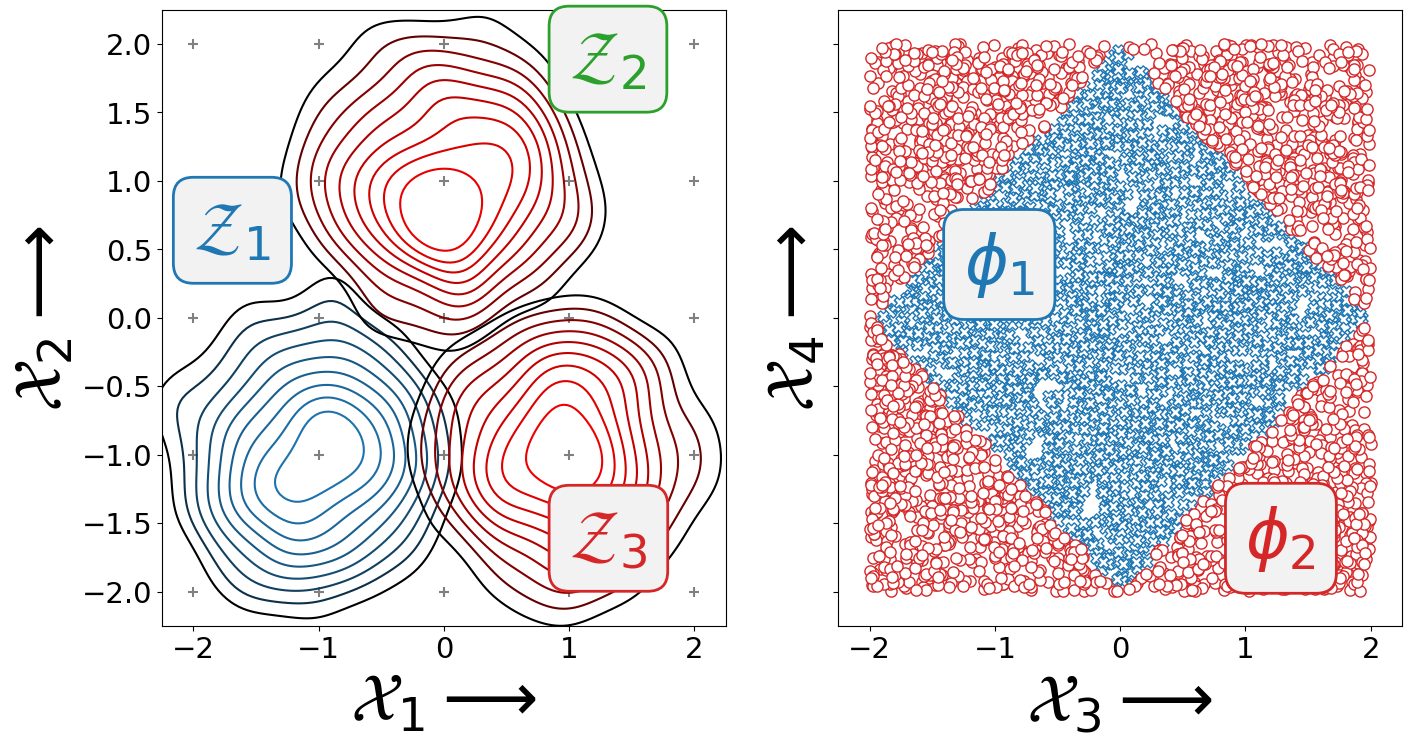

In [11]:
plot_synthetic_data(outcomes, features, interventions)

<a id="splitdata"></a>
### 2.3 Split Dataset into  Train and Test folds

In [17]:
# 超参数：设置随机种子和测试集比例，保证结果可复现
random_seed = 0          # 随机种子，固定后每次运行得到的训练/测试划分一致
test_size = 0.25         # 测试集占总数据的比例，25% 用于测试，75% 用于训练

# 将合成数据拆分为训练集和测试集
import numpy as np       # 导入 numpy，用于随机采样和数组操作

np.random.seed(random_seed)  # 固定随机数种子，确保每次划分相同
n = features.shape[0]        # 获取样本总数，features 应为 DataFrame 或数组

# 构造测试集索引：先创建全 False 的布尔数组，再随机将 25% 位置置为 True
test_idx = np.zeros(n).astype('bool')                          # 初始全 False
test_idx[np.random.randint(n, size=int(n*test_size))] = True     # 随机选 25% 索引置 True

# 利用布尔索引拆分原始数据：~test_idx 为训练集索引
features_tr = features.iloc[~test_idx]   # 训练集特征（DataFrame）
outcomes_tr = outcomes.iloc[~test_idx] # 训练集结局（DataFrame）
interventions_tr = interventions[~test_idx]  # 训练集干预（数组或 DataFrame）
print(f'Number of training data points: {len(features_tr)}')  # 打印训练样本数

features_te = features.iloc[test_idx]   # 测试集特征
outcomes_te = outcomes.iloc[test_idx]   # 测试集结局
interventions_te = interventions[test_idx]  # 测试集干预
print(f'Number of test data points: {len(features_te)}')  # 打印测试样本数

# 将拆分后的数据转换为 float32 类型，满足后续模型输入要求
x_tr = features_tr.values.astype('float32')  # 训练集特征数组
t_tr = outcomes_tr['time'].values.astype('float32')  # 训练集时间（生存分析中的观察时间）
e_tr = outcomes_tr['event'].values.astype('float32')  # 训练集事件（是否发生事件，1/0）
a_tr = interventions_tr.values.astype('float32')  # 训练集干预（治疗或处理变量）

x_te = features_te.values.astype('float32')  # 测试集特征数组
t_te = outcomes_te['time'].values.astype('float32')  # 测试集时间
e_te = outcomes_te['event'].values.astype('float32')  # 测试集事件
a_te = interventions_te.values.astype('float32')  # 测试集干预

# 打印训练集各维度信息，方便检查数据形状是否正确
print('Training Data Statistics:')
print(f'Shape of covariates: {x_tr.shape} | times: {t_tr.shape} | events: {e_tr.shape} | interventions: {a_tr.shape}')

Number of training data points: 3899
Number of test data points: 1101
Training Data Statistics:
Shape of covariates: (3899, 8) | times: (3899,) | events: (3899,) | interventions: (3899,)


In [18]:
def find_max_treatment_effect_phenotype(g, zeta_probs, factual_outcomes):
    """
    逐行解释：
    1. 函数名：find_max_treatment_effect_phenotype
       作用：从 g 个“治疗表型”分组中，找出“平均差异生存”最大的那一组的索引。
       用法：传入治疗表型数量 g、每个个体属于各表型的概率矩阵 zeta_probs、以及事实结果元组 factual_outcomes，
             返回最具治疗效应的表型组编号（0 到 g-1）。

    2. mean_differential_survival = np.zeros(zeta_probs.shape[1])
       解释：初始化一个长度为 g 的零数组，用于存放每个表型组的“平均差异生存”值。
       用法：zeta_probs.shape[1] 就是 g，即表型组数。

    3. outcomes_train, interventions_train = factual_outcomes
       解释：将 factual_outcomes 元组拆成两个变量：
            outcomes_train —— 个体的生存/结果数据（pd.Series 或 pd.DataFrame）；
            interventions_train —— 个体实际接受的治疗方式（pd.Series）。
       用法：确保 factual_outcomes 是长度为 2 的元组或列表。

    4. for gr in range(g):
       解释：遍历每一个治疗表型组 gr（0 到 g-1）。

    5. zeta_probs_g = zeta_probs[:, gr]
       解释：取出所有个体属于第 gr 个表型的概率向量。
       用法：zeta_probs 是 (n_samples, g) 的二维数组。

    6. z_mask = zeta_probs_g > np.quantile(zeta_probs_g, 0.75)
       解释：只保留概率值处于该表型 top 25% 的个体，生成布尔掩码。
       用法：后续计算仅在这 25% 的“高置信”个体上进行，减少噪声。

    7. mean_differential_survival[gr] = find_mean_differential_survival(
           outcomes_train.loc[z_mask], interventions_train.loc[z_mask])
       解释：调用外部函数，计算该表型高概率子群体的“平均差异生存”指标。
       用法：find_mean_differential_survival 需要两个对齐的 pd.Series/DataFrame。

    8. return np.nanargmax(mean_differential_survival)
       解释：返回“平均差异生存”最大的表型组索引；若出现 NaN 则忽略。
       用法：最终决策依据，可直接用于后续分析或报告。
    """
    mean_differential_survival = np.zeros(zeta_probs.shape[1])  # 存放每组效应值
    outcomes_train, interventions_train = factual_outcomes      # 拆包事实结果

    # 遍历每个治疗表型组
    for gr in range(g):
        # 取出属于该表型的概率
        zeta_probs_g = zeta_probs[:, gr]
        # 只保留概率 top 25% 的个体
        z_mask = zeta_probs_g > np.quantile(zeta_probs_g, 0.75)
        # 计算该子群体的平均差异生存
        mean_differential_survival[gr] = find_mean_differential_survival(
            outcomes_train.loc[z_mask], interventions_train.loc[z_mask])

    # 返回效应最大的组索引
    return np.nanargmax(mean_differential_survival)

<a id="phenotyping"></a>
## 3. Counterfactual Phenotyping

<a id="phenocmhe"></a>
### 3.1 Counterfactual Phenotyping with CMHE

In [19]:
# Hyper-parameters to train model
k = 1                       # 基础生存表型数量：模型假设存在 1 个潜在的“基础生存亚型”
g = 2                       # 治疗效果表型数量：模型假设存在 2 个潜在的“治疗效应亚型”，用于捕捉不同患者对治疗的异质性反应
layers = [50, 50]           # 隐藏层神经元数量列表：构建一个两层隐藏层、每层 50 个神经元的全连接网络

random_seed = 10            # 随机种子：固定 10 可保证每次运行代码时数据划分、参数初始化等随机过程结果一致，方便复现实验
iters = 100                 # 训练轮数（epochs）：整个训练集将被完整遍历 100 次
learning_rate = 0.01        # 学习率：优化器每次参数更新的步长，0.01 为相对保守的初始值
batch_size = 256            # 批大小：每前向/反向传播使用 256 条样本，平衡内存占用与梯度稳定性
vsize = 0.15                # 验证集比例：从训练数据中划分 15 % 作为验证集，用于监控过拟合
patience = 3                # 早停耐心轮数：若验证集损失连续 3 个 epoch 未下降，则提前终止训练，防止过拟合
optimizer = "Adam"          # 优化器名称：采用 Adam 优化器，结合动量与自适应学习率，适合大多数深度学习任务


In [20]:
# 从 auton_survival 库中导入 DeepCoxMixturesHeterogenousEffects 模型类，
# 该类用于基于 Deep Cox Mixtures 框架估计异质性处理效应（HTE）。
from auton_survival.models.cmhe import DeepCoxMixturesHeterogenousEffects

# 设置 PyTorch 的随机种子，保证神经网络权重初始化可复现。
torch.manual_seed(random_seed)
# 设置 NumPy 的随机种子，保证后续任何依赖 NumPy 的随机操作可复现。
np.random.seed(random_seed)

# 实例化 CMHE 模型：
# random_seed：随机种子，用于模型内部随机初始化；
# k：指定潜在子群（latent subgroups）数量，模型会尝试将样本划分到 k 个子群；
# g：指定每个子群内部 Cox 成分的数量，用于建模每个子群内的生存分布；
# layers：一个列表，定义隐藏层神经元数量，例如 [32, 16] 表示两个隐藏层，分别 32 和 16 个神经元。
model = DeepCoxMixturesHeterogenousEffects(random_seed=random_seed, k=k, g=g, layers=layers)

# 训练模型：
# x_tr：训练集协变量（特征矩阵），形状为 (n_samples, n_features)；
# t_tr：训练集事件发生时间（time-to-event），形状为 (n_samples,)；
# e_tr：训练集事件指示符（event indicator），1 表示事件发生（如死亡），0 表示右删失；
# a_tr：训练集处理/暴露变量（treatment/exposure），用于估计处理效应；
# vsize：验证集比例（0–1 之间），若 val_data 为 None，则从训练数据中随机划分出该比例作为验证集；
# val_data：可选，直接提供验证集元组 (x_val, t_val, e_val, a_val)，若提供则 vsize 参数被忽略；
# iters：最大训练迭代次数（epochs）；
# learning_rate：优化器学习率；
# batch_size：每批样本量；
# optimizer：字符串或 torch.optim.Optimizer 类，指定优化算法，如 'Adam'；
# patience：早停（early stopping）容忍度，若验证集损失在 patience 次迭代内无改善，则提前终止训练。
# 函数返回训练好的模型实例，可继续用于预测、评估或解释。
model = model.fit(x_tr, t_tr, e_tr, a_tr, vsize=vsize, val_data=None, iters=iters, 
                  learning_rate=learning_rate, batch_size=batch_size, 
                  optimizer=optimizer, patience=patience)

  0%|          | 0/100 [00:00<?, ?it/s]d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\auton_survival\models\cmhe\cmhe_utilities.py:121: RuntimeWarning: invalid value encountered in log
  probs.append(np.log(event_probs))
  1%|          | 1/100 [00:00<00:21,  4.62it/s]d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\auton_survival\models\cmhe\cmhe_utilities.py:71: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\auton_survival\models\cmhe\cmhe_utilities.py:66: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
 41%|████      | 41/100 [00:08<00:11,  4.97it/s]


In [ ]:
# 打印模型学习到的 g 个潜在治疗效应参数 omega（需先 detach 从计算图中取出）
print(f'Treatment Effect for the {g} groups: {model.torch_model[0].omega.detach()}')


Treatment Effect for the 2 groups: tensor([-0.5346,  0.4080])


In [23]:

# 用训练集特征 x_tr 推断每个样本属于各个潜在治疗表型 zeta 的概率
zeta_probs_train = model.predict_latent_phi(x_tr)
# 取概率最大的索引作为该样本的表型标签
zeta_train =  np.argmax(zeta_probs_train, axis=1)
# 统计训练集中各表型的人数分布
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')


Distribution of individuals in each treatement phenotype in the training data: [1786 2113]


In [28]:
zeta_train[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [29]:
zeta_probs_train[:5]

array([[0.00123885, 0.9987612 ],
       [0.09365809, 0.90634197],
       [0.04955222, 0.95044774],
       [0.26870525, 0.7312948 ],
       [0.12428816, 0.8757118 ]], dtype=float32)

In [33]:
np.unique(zeta_train, return_counts=True)

(array([0, 1], dtype=int64), array([1786, 2113], dtype=int64))

In [34]:
outcomes_tr[:5]

,event,time,uncensored time treated,uncensored time control,Z,Zeta
1,True,3.493217,3.493217,6.307030,2.0,0.0
2,True,2.558462,1.476810,2.558462,1.0,0.0
3,True,5.582874,5.582874,4.593198,1.0,0.0
4,True,6.675284,3.477266,6.675284,0.0,1.0
5,True,6.697944,6.697944,6.506437,2.0,0.0


In [35]:

# 根据训练集结果与干预信息，找出在 2 个表型中“受限平均生存时间”最大的表型索引
max_treat_idx_CMHE = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
# 打印该最优表型编号
print(f'\nGroup {max_treat_idx_CMHE} has the maximum restricted mean survival time on the training data!')


Group 1 has the maximum restricted mean survival time on the training data!


d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", e

### Evaluate CMHE on Test Data

In [36]:
# 逐行解释并说明用法
# 1. 对测试集的每个样本，调用模型方法 predict_latent_phi 得到其属于各个潜在治疗表型（latent phenotype）的概率
#    返回的 zeta_probs_test_CMHE 形状为 (n_samples, n_phenotypes)，每行和为 1
zeta_probs_test_CMHE = model.predict_latent_phi(x_te)

# 2. 取概率最大的那一列的索引，作为该样本被分配的表型标签
#    np.argmax(..., axis=1) 在每一行里找最大值所在列，返回长度为 n_samples 的一维数组
zeta_test = np.argmax(zeta_probs_test_CMHE, axis=1)


In [38]:
outcomes_te[:5]


,event,time,uncensored time treated,uncensored time control,Z,Zeta
0,True,3.238760,3.238760,0.009182,1.0,0.0
7,False,4.584259,3.640417,10.772226,2.0,1.0
21,True,3.719086,3.719086,10.162720,2.0,1.0
24,True,5.134909,5.134909,3.056659,0.0,0.0
25,True,3.147192,2.333987,3.147192,1.0,0.0


In [39]:
zeta_probs_test_CMHE

array([[0.00314804, 0.996852  ],
       [0.89368176, 0.10631821],
       [0.9457787 , 0.05422127],
       ...,
       [0.03702996, 0.96297   ],
       [0.08100144, 0.9189986 ],
       [0.09510624, 0.9048938 ]], dtype=float32)

Distribution of individuals in each treatment phenotype in the test data: [534 567]


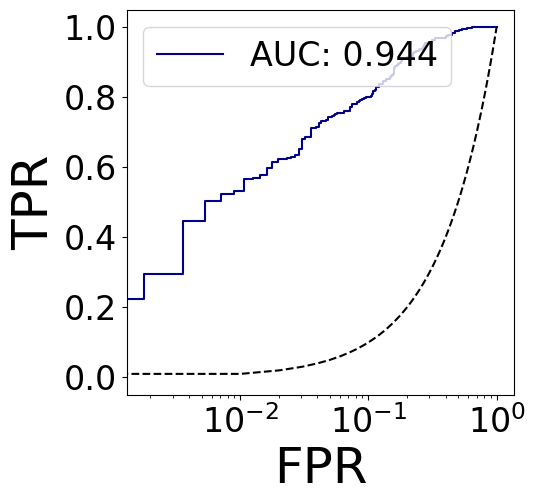

In [37]:

# 3. 统计并打印测试集中各表型的人数分布
#    np.unique 返回两个数组：唯一值及其出现次数，这里取后者用于展示
print(f'Distribution of individuals in each treatment phenotype in the test data: '
      f'{np.unique(zeta_test, return_counts=True)[1]}')

# 4. 评估模型区分“最大治疗效应表型”的能力
#    从概率矩阵中取出对应最大治疗效应表型的那一列，与真实结果 outcomes_te 一起画 ROC 曲线
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CMHE[:, max_treat_idx_CMHE])

<a id="clustering"></a>
### 3.3 Comparison with the Clustering phenotyper

我们将 CMHE 的能力与降维后再聚类的方法进行对比，用于反事实表型分析。具体而言，我们首先对输入的混杂变量 $\mathbf{x}$ 进行降维，然后进行聚类。由于合成数据中的混杂变量数量较少，在接下来的实验中，我们直接使用具有 2 个分量和协方差矩阵为对角矩阵的高斯混合模型（GMM）进行聚类。


In [41]:
# 导入用于聚类表型分析的类
from auton_survival.phenotyping import ClusteringPhenotyper
# 导入计算 AUC 的指标（虽然此处未实际使用，但常见于后续评估）
from sklearn.metrics import auc

# 指定聚类算法为 Gaussian Mixture Model（高斯混合模型）
clustering_method = 'gmm'
# 不对合成数据集做降维处理，因此设为 None
dim_red_method = None # We would not perform dimensionality reduction for the synthetic dataset
# 降维后的维数，此处未启用降维，保持 None
n_components = None 
# 期望聚出的“潜在治疗效果表型”簇的数量
n_clusters = 2 # Number of underlying treatment effect phenotypes

# 实例化聚类表型分析器，固定随机种子保证结果可复现
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                  dim_red_method=dim_red_method, 
                                  n_components=n_components, 
                                  n_clusters=n_clusters,
                                  random_seed=36)


In [42]:
# 1. 使用训练集特征拟合 phenotyper 模型，并立即对同一训练集预测每个样本属于各个潜在治疗表型（phenotype）的概率
#    返回的 zeta_probs_train 是一个二维数组，每行对应一个样本，每列对应一个表型的概率
zeta_probs_train = phenotyper.fit(features_tr.values).predict_proba(features_tr.values)

# 2. 再次在训练集上拟合 phenotyper，并直接输出每个样本被分配到的表型标签（硬分配）
#    zeta_train 是一维数组，元素为 0/1/.../k-1，表示每个样本所属的表型
zeta_train = phenotyper.fit_predict(features_tr.values)

# 3. 打印训练集中各表型的样本数量分布
#    np.unique(..., return_counts=True) 会返回唯一值及其出现次数，这里只取计数部分
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')


No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=36)
No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=36)
Distribution of individuals in each treatement phenotype in the training data: [1285 1425 1189]


In [43]:

# 4. 根据训练集的概率预测、真实结局（如生存时间）和干预信息，找出“限制性平均生存时间”最大的表型组
#    g=2 表示假设共有 2 个潜在表型；函数返回的是组索引（0 或 1）
max_treat_idx_CP = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))

# 5. 打印提示：在训练数据上，哪个组获得了最大的限制性平均生存时间
print(f'\nGroup {max_treat_idx_CP} has the maximum restricted mean survival time on the training data!')


Group 0 has the maximum restricted mean survival time on the training data!


d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", e

### Evaluate Clustering Phenotyper on Test Data

Distribution of individuals in each treatement phenotype in the test data: [356 370 375]


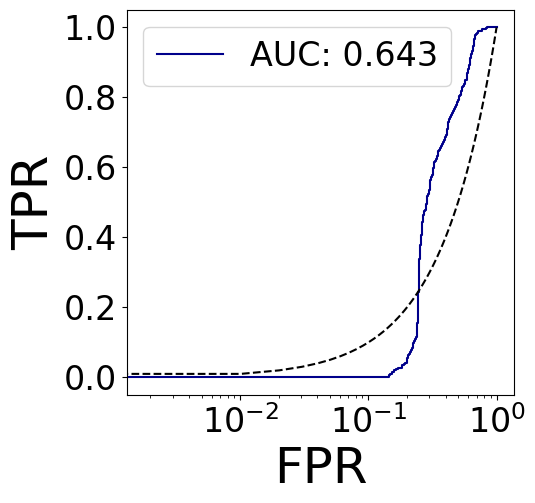

In [44]:
# 逐行解释并说明用法：
# 1. 对测试集中每个个体，计算其属于“最大处理效应组”的概率
# 2. 使用在训练集上训练好的 phenotyper 模型，对测试集特征 x_te 进行预测，返回每个个体属于各个亚组的概率矩阵
zeta_probs_test_CP = phenotyper.predict_proba(x_te)

# 3. 取概率最大的列索引作为该个体的预测亚组标签
zeta_test_CP =  np.argmax(zeta_probs_test_CP, axis=1)

# 4. 打印测试集中各亚组的个体数量分布，便于直观查看每类有多少人
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test_CP, return_counts=True)[1]}')

# 5. 绘制 ROC 曲线，评估模型在“最大处理效应亚组”上的分类性能；
#    outcomes_te 为真实结果，zeta_probs_test_CP[:, max_treat_idx_CP] 为对应亚组的预测概率
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CP[:, max_treat_idx_CP])

<a id="regression"></a>
## 4. CMHE for Factual Regression

为完整起见，我们进一步使用标准生存分析指标评估 CMHE 在多个时间范围内估计事实风险的性能，包括：
1. $\textbf{Brier 分数} \ (\textrm{BS})$：定义为在某一时间范围内对概率预测的均方误差（MSE）。

\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}
2. $ \textbf{时间依赖性一致性指数} \ (C^{\text{td}}$)：一种排序统计量，用于计算模型在特定时间范围内根据估计风险对患者进行排序的性能。
\begin{align}
C^{td }(t) = \mathbf{P}\big( \hat{F}(t| \mathbf{x}_i) > \hat{F}(t| \mathbf{x}_j)  | \delta_i=1, T_i<T_j, T_i \leq t \big) 
\end{align}
我们计算时间依赖性一致性指数的删失调整估计值（Antolini 等，2005；Gerds 等，2013）和综合 Brier 分数（即在 1 年、3 年和 5 年时间范围内对 Brier 分数进行积分。$\text{IBS} = \mathop{\sum}_t  \frac{t}{t_\text{max}}  \cdot \text{BS}(t)$）（Gerds 和 Schumacher，2006；Graf 等，1999），以评估多个时间范围内的判别性能和模型校准。
*我们发现，CMHE 的判别性能与具有 MLP 风险函数的简单 Cox 模型相似或更好。CMHE 的校准也更好，这体现在整体较低的综合 Brier 分数上，表明其在事实风险估计中的实用性。*



<a id="regcmhe"></a>

### 4.1 Factual Regression Performance of  CMHE

In [49]:
# 定义评估时间点：1 年、3 年、5 年
horizons = [1, 3, 5]

# 使用训练好的 CMHE 模型在测试集上预测上述时间点的生存概率
# x_te: 测试集协变量；a_te: 测试集治疗变量；t=horizons 指定预测时间点
predictions_test_CMHE = model.predict_survival(x_te, a_te, t=horizons)

# 调用 factual_evaluate 计算评估指标：
# 输入训练元组 (x_tr, t_tr, e_tr, a_tr) 与测试元组 (x_te, t_te, e_te, a_te)
# 返回对应 1、3、5 年的 Concordance Index (CI) 以及 Integrated Brier Score (IBS)
CI1, CI3, CI5, IBS = factual_evaluate((x_tr, t_tr, e_tr, a_tr), (x_te, t_te, e_te, a_te), 
                                      horizons, predictions_test_CMHE)

# 打印结果，保留四位小数
print(f'Concordance Index (1 Year): {np.around(CI1, 4)} (3 Year) {np.around(CI3, 4)}: (5 Year): {np.around(CI5, 4)}')
print(f'Integrated Brier Score: {np.around(IBS, 4)}')

Concordance Index (1 Year): 0.7119 (3 Year) 0.7059: (5 Year): 0.7059
Integrated Brier Score: 0.1498


<a id="deepcph"></a>
### 4.2 Comparison with Deep Cox-Proportional Hazards Model

In [ ]:
# 从 auton_survival 库中导入 SurvivalModel 类，用于构建生存分析模型
from auton_survival.estimators import SurvivalModel

# 实例化一个 Deep Cox-proportional Hazard（DCPH）模型
# 'dcph'：指定模型类型为深度 Cox 比例风险模型
# random_seed=0：设置随机种子，保证结果可复现
# bs=100：训练时每个 mini-batch 的样本数为 100
# learning_rate=1e-3：优化器学习率设为 0.001
# layers=[50, 50]：神经网络包含两个隐藏层，每层 50 个神经元，默认使用 tanh 激活
dcph_model = SurvivalModel('dcph', random_seed=0, bs=100, learning_rate=1e-3, layers=[50, 50])

# 将干预变量（treatment）在训练集和测试集中的 Series 名称统一设为 'treat'，方便后续引用
interventions_tr.name, interventions_te.name = 'treat', 'treat'

# 将干预变量转换为 float64 类型后，与原始特征拼接，形成新的训练特征矩阵
features_tr_dcph = pd.concat([features_tr, interventions_tr.astype('float64')], axis=1)

# 同理，构造测试特征矩阵
features_te_dcph = pd.concat([features_te, interventions_te.astype('float64')], axis=1)

# 将训练集的结局（事件指示与时间）整理成 DataFrame，列名分别为 'event' 和 'time'，并统一为 float64 类型
outcomes_tr_dcph = pd.DataFrame(outcomes_tr, columns=['event', 'time']).astype('float64')

# 使用拼接后的训练特征和结局数据，拟合 DCPH 模型
dcph_model = dcph_model.fit(features_tr_dcph, outcomes_tr_dcph)

100%|██████████| 50/50 [00:01<00:00, 28.56it/s]


### Evaluate DCPH on Test Data

In [51]:
# 在测试数据上计算生存预测概率
# dcph_model: 已训练好的离散Cox比例风险模型
# features_te_dcph: 测试集的特征矩阵
# horizons: 需要评估的时间点列表，如[12, 36, 60] 表示1年、3年、5年（单位：月）
predictions_test_DCPH = dcph_model.predict_survival(features_te_dcph, horizons)

# 调用 factual_evaluate 函数，计算多个生存分析评价指标
# 输入参数：
#   (x_tr, t_tr, e_tr, a_tr): 训练集特征、生存时间、事件指示器、处理/暴露变量
#   (x_te, t_te, e_te, a_te): 测试集特征、生存时间、事件指示器、处理/暴露变量
#   horizons: 同上，评估时间点
#   predictions_test_DCPH: 模型在测试集上的生存概率预测
# 返回值：
#   CI1, CI3, CI5: 分别在1年、3年、5年时间点的Concordance Index（C-index），衡量模型区分度，越接近1越好
#   IBS: Integrated Brier Score，综合Brier分数，衡量预测概率与真实状态的校准度，越小越好
CI1, CI3, CI5, IBS = factual_evaluate((x_tr, t_tr, e_tr, a_tr), (x_te, t_te, e_te, a_te), 
                                      horizons, predictions_test_DCPH)

# 打印1年、3年、5年的C-index，保留4位小数
print(f'Concordance Index (1 Year): {np.around(CI1, 4)} (3 Year) {np.around(CI3, 4)}: (5 Year): {np.around(CI5, 4)}')
# 打印综合Brier分数，保留4位小数
print(f'Integrated Brier Score: {np.around(IBS, 4)}')

Concordance Index (1 Year): 0.6889 (3 Year) 0.6912: (5 Year): 0.6962
Integrated Brier Score: 0.1537


In [26]:
features

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.148745,1.892484,0.195254,0.860757,0.696523,0.483697,0.339551,0.374794
1,1.139439,-0.943330,0.411054,0.179533,0.428686,0.683057,0.600948,0.070483
2,-0.961237,0.782706,-0.305381,0.583576,0.157478,0.070556,0.034590,0.776005
3,0.466508,0.694348,-0.249651,1.567092,0.850959,0.416178,0.968841,0.863598
4,-0.249002,-0.552091,1.854651,-0.466234,0.860385,0.367184,0.954347,0.748930
...,...,...,...,...,...,...,...,...
4995,0.377835,2.432757,0.779933,-1.221572,0.505301,0.928557,0.328742,0.207052
4996,-1.018245,-1.553523,-1.543853,-0.951537,0.481382,0.437604,0.743311,0.292312
4997,-1.585228,-0.796665,0.942009,0.201787,0.155891,0.634361,0.544946,0.011244
4998,0.254141,1.583503,-0.411395,1.033718,0.452547,0.369376,0.054975,0.567739
